# Notebook exploration et traitement
Ce notebook se dédie à configurer l'environnement mlflow. Prépare l'echantillon. Nettoie les parties textes des titres et des messages. Rassemble les tags les plus récurrents sous forme de liste de 20 tags.

Il a une partie ou le texte est réduit en Bag of Word. 
Réduit en principaux composants, en vecteur avec SVD. Le résultat est enregistré dans mlflow.

Une deuxieme partie ou les textes sont transformés en Word2vec. Le resultat est enregistré dans mlflow pour un usage ultérieur.

Une troisieme partie test avec un model pré-entrainé avec Universal Sentence Encoder.
Enregistré dans mlflow.


In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
import mlflow
import mlflow.keras
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np
import tensorflow_hub as hub
import os
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

# Charge les variables d'environnement et configure MLflow
load_dotenv()
tracking_uri = "https://mlflowp51-975919512217.us-central1.run.app"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Text_Processing_Experiment")

print("Tracking URI:", mlflow.get_tracking_uri())

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../f8bc1d91ca98.json"



Tracking URI: https://mlflowp51-975919512217.us-central1.run.app


In [2]:
df = pd.read_csv('db/questions_db.csv')
print(df.head())

# Réduit l'échantillon
df = df.sample(frac=0.1, random_state=42)

# Supprime une colonne (temporairement)
del df['FavoriteCount']  

                                               Title  \
0  C++ function template specialization based on ...   
1   How can I write a std::apply on a std::expected?   
2  App must target Android 14 (API level 34) or h...   
3  Efficiently find the number of different class...   
4  Get the first and last number occuring in a (t...   

                                                Body  \
0  <p>In C++20, instead of doing</p>\n<pre><code>...   
1  <p>In C++23, given:</p>\n<pre><code>expected&l...   
2  <p>I updated the target API level (targetsdkve...   
3  <p>I have been stuck with computing efficientl...   
4  <div class="s-table-container"><table class="s...   

                                                Tags        Id  Score  \
0  <c++><templates><overloading><template-special...  78744341      1   
1  <c++><functional-programming><monads><c++23><s...  78734779     15   
2  <flutter><upgrade><google-play-console><androi...  78729452      1   
3                     <r><performa

In [3]:

# Nettoie les colonnes 'Title' et 'Body'
def clean_text(text):
    if isinstance(text, str):
        # Supprime les balises HTML et leur contenu
        text = re.sub(r'<[^>]*>', '', text)  
        
        # Supprime les caractères spéciaux qui ne sont pas des lettres ou des espaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)  
        
        # Supprime les mots de 2 lettres ou moins
        return ' '.join([word for word in text.split() if len(word) > 2])  
    return text

# Nettoyage des titres et corps
df['Cleaned_Title'] = df['Title'].apply(clean_text)
df['Cleaned_Body'] = df['Body'].apply(clean_text)

# Ajout des nouvelles features
def add_features(df):
    df['Title_length'] = df['Title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['Body_word_count'] = df['Body'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['Tag_count'] = df['Tags'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    return df

df = add_features(df)

# Suivi MLflow pour nettoyage de texte et extraction de features
with mlflow.start_run(run_name="Text Cleaning and Features"):
    mlflow.log_param("num_rows", len(df))
    mlflow.log_param("num_columns", df.shape[1])

    # Log d'un échantillon des données nettoyées
    sample_cleaned = df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head(10)
    sample_cleaned.to_csv("cleaned_data_sample.csv", index=False)
    mlflow.log_artifact("cleaned_data_sample.csv")

    print("Données nettoyées et features ajoutées avec succès.")
mlflow.end_run()


2024/10/06 16:49:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Text Cleaning and Features at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/53bfede0e0e44a67b57f304b0bd1b954.
2024/10/06 16:49:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


Données nettoyées et features ajoutées avec succès.


In [4]:
def process_tags(tags):
    if isinstance(tags, str):
        return tags.strip('<>').split('><')
    else:
        return []

df['Tags'] = df['Tags'].apply(process_tags)


Nombre total de tags extraits: 14944
['javascript', 'python', 'android', 'java', 'reactjs', 'html', 'flutter', 'arrays', 'css', 'angular', 'node.js', 'c#', 'python-3.x', 'dart', 'php', 'typescript', 'ios', 'react-native', 'jquery', 'list']


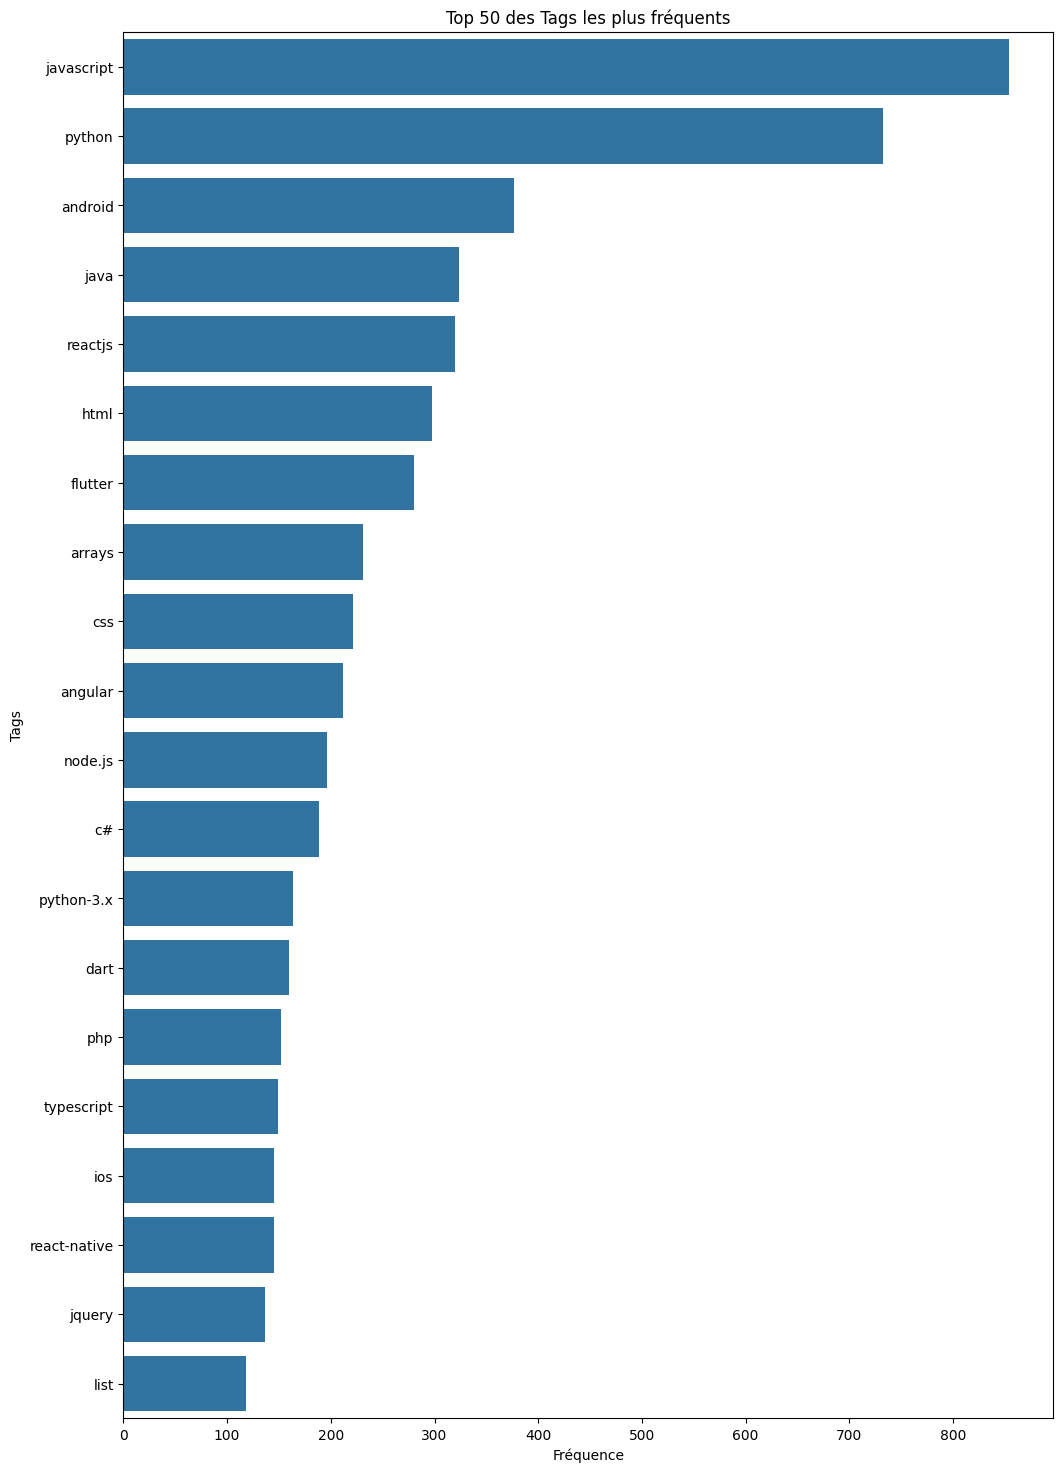

In [5]:
# Extraction des tags et sélection des 50 plus fréquents
all_tags = [tag for tags in df['Tags'] for tag in tags]

if all_tags:
    print(f"Nombre total de tags extraits: {len(all_tags)}")
else:
    print("Erreur : Aucun tag n'a été extrait")

tag_counts = pd.Series(all_tags).value_counts().head(20)
top_tags = list(tag_counts.index)

    # Filtrage des questions avec les top 50 tags
df['Filtered_Tags'] = df['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df = df[df['Filtered_Tags'].apply(lambda x: len(x) > 0)]

print(top_tags)
plt.figure(figsize=(12, 18))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 50 des Tags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Tags')
plt.show()


In [6]:
# Transformation en BoW
def transform_text_to_bow(df, max_df=0.95, min_df=2, n_components=50):  # Réduction des composants
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    X = vectorizer.fit_transform(df['Cleaned_Body'])
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X)
    mlb = MultiLabelBinarizer(classes=top_tags)
    y = mlb.fit_transform(df['Filtered_Tags'])
    return X_reduced, y, vectorizer, svd, mlb


# Suivi MLflow pour BoW
with mlflow.start_run(run_name="BoW Transformation"):
    X_reduced, y, vectorizer, svd, mlb = transform_text_to_bow(df)

    # Log de la variance expliquée par SVD
    explained_variance = svd.explained_variance_ratio_.sum()
    mlflow.log_metric("explained_variance", explained_variance)
    
    # Log des dimensions des matrices après réduction
    mlflow.log_metric("X_reduced_num_rows", X_reduced.shape[0])
    mlflow.log_metric("X_reduced_num_columns", X_reduced.shape[1])
    mlflow.log_metric("num_labels", y.shape[1])

    os.makedirs("model", exist_ok=True)

    # Enregistrement des objets comme artefacts
    with open("model/vectorizer.pkl", 'wb') as f:
        pickle.dump(vectorizer, f)
    with open("model/svd.pkl", 'wb') as f:
        pickle.dump(svd, f)
    with open("model/mlb.pkl", 'wb') as f:
        pickle.dump(mlb, f)

    mlflow.log_artifact("model/vectorizer.pkl")
    mlflow.log_artifact("model/svd.pkl")
    mlflow.log_artifact("model/mlb.pkl")
mlflow.end_run()



2024/10/06 16:49:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run BoW Transformation at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/ad29f28165bb44dba2fe3ecae073e38e.
2024/10/06 16:49:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


In [7]:
def train_word2vec(df, column='Cleaned_Body', vector_size=50, window=5, min_count=3, workers=4):
    sentences = df[column].apply(word_tokenize).tolist()
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

    def document_vector(doc):
        doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
        return np.mean(word2vec_model.wv[doc], axis=0) if doc else np.zeros(vector_size)

    df['word2vec_vector'] = df[column].apply(lambda x: document_vector(word_tokenize(x)))
    X_word2vec = np.vstack(df['word2vec_vector'].values)

    word2vec_model.save("model/word2vec_model.model")
    return X_word2vec, "model/word2vec_model.model"

# Suivi MLflow pour Word2Vec
with mlflow.start_run(run_name="Word2Vec Training"):
    X_word2vec, model_path = train_word2vec(df, column='Cleaned_Body')

    # Log de la taille des vecteurs Word2Vec
    mlflow.log_metric("word2vec_num_rows", X_word2vec.shape[0])
    mlflow.log_metric("word2vec_num_columns", X_word2vec.shape[1])

    # Log de la taille moyenne des vecteurs générés
    vector_lengths = np.linalg.norm(X_word2vec, axis=1)
    mlflow.log_metric("mean_vector_length", np.mean(vector_lengths))
    mlflow.log_metric("std_vector_length", np.std(vector_lengths))

    mlflow.log_artifact(model_path, artifact_path="models/word2vec_model")
mlflow.end_run()



2024/10/06 16:49:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Word2Vec Training at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1/runs/65568803de664c1283ac444464f51c39.
2024/10/06 16:49:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflowp51-975919512217.us-central1.run.app/#/experiments/1.


In [8]:
import os
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import logging

# Configure le logging
logging.basicConfig(level=logging.INFO)

# Utilise les titres nettoyés (on supprime ceux qui sont vides)
df_cleaned_Body = [body for body in df['Cleaned_Body'].tolist() if body.strip()]

# Charge le modèle USE depuis TensorFlow Hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_url, trainable=False)

# Génére les embeddings par lots (pour éviter de tout calculer d'un coup)
def generate_embeddings_in_batches(texts, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        logging.info(f"Traitement du lot {i//batch_size + 1}")
        batch_embeddings = use_layer(texts[i:i+batch_size])
        embeddings.append(np.array(batch_embeddings))
    return np.vstack(embeddings)

# Vérifie si les embeddings sont déjà sauvegardés, sinon les calculer
embeddings_file = 'embeddings.npy'
if not os.path.exists(embeddings_file):
    logging.info("Calcul des embeddings...")
    X_use_np = generate_embeddings_in_batches(df_cleaned_Body, batch_size=100)
    np.save(embeddings_file, X_use_np)  # Sauvegarde les embeddings
    logging.info(f"Embeddings sauvegardés dans {embeddings_file}.")
else:
    logging.info(f"Chargement des embeddings depuis {embeddings_file}.")
    X_use_np = np.load(embeddings_file)

y_filtered = y[:len(X_use_np)] 
# Divise les données en entraînement (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_use_np, y_filtered, test_size=0.2, random_state=42)

# Définit un modèle simple avec 2 couches denses
model_use = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_use_np.shape[1],)),  # 8 neurones
    tf.keras.layers.Dropout(0.2),  # Dropout pour éviter le surapprentissage
    tf.keras.layers.Dense(4, activation='relu'),  # 4 neurones
    tf.keras.layers.Dense(y.shape[1], activation='sigmoid')  # Couche de sortie
])

# Compile le modèle
model_use.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Utilise early stopping pour arrêter l'entraînement si les résultats se dégradent
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîne le modèle (une seule époque pour tester rapidement)
history_use = model_use.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=128, callbacks=[early_stopping])

# Prédictions sur les données de test
y_pred = (model_use.predict(X_test) > 0.5).astype("int32")

# Calcul des métriques supplémentaires
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Suivi dans MLflow : enregistrement du modèle et des résultats
with mlflow.start_run(run_name="USE Training Optimized with Metrics"):
    mlflow.keras.log_model(model_use, "model_use")

    # Log d'entraînement
    mlflow.log_metric("accuracy_train", history_use.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy_train", history_use.history['val_accuracy'][-1])
    
    # Log calculé sur le jeu de test
    mlflow.log_metric("accuracy_test", accuracy)
    mlflow.log_metric("precision_test", precision)
    mlflow.log_metric("recall_test", recall)
    mlflow.log_metric("f1_score_test", f1)

logging.info("Modèle entraîné et suivi dans MLflow avec les métriques enrichies.")

print(f"Exemple d'embeddings USE :\n{X_use_np[:2]}")  # Affiche deux premiers exemples d'embeddings
print(f"Shape des embeddings USE : {X_use_np.shape}")


INFO:absl:Using C:\Users\leenc\AppData\Local\Temp\tfhub_modules to cache modules.



INFO:absl:Fingerprint not found. Saved model loading will continue.
INFO:absl:path_and_singleprint metric could not be logged. Saved model loading will continue.



INFO:root:Chargement des embeddings depuis embeddings.npy.
c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0333 - loss: 0.6928 - val_accuracy: 0.0000e+00 - val_loss: 0.6923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leenc\Documents\openclassrooms\p5\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

Exemple d'embeddings USE :
[[-0.06617208  0.02476599  0.01110613 ...  0.07282789 -0.01593303
  -0.07097346]
 [-0.04433645 -0.03264523 -0.02808888 ...  0.06767163 -0.02526903
  -0.06775778]]
Shape des embeddings USE : (38, 512)


In [9]:
# Sauvegarder les artefacts et les modèles
save_path = 'mlflow_artifacts/'
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, 'df.pkl'), 'wb') as f:
    pickle.dump(df, f)
mlflow.log_artifact(os.path.join(save_path, 'df.pkl'))

with open(os.path.join(save_path, 'X_reduced.pkl'), 'wb') as f:
    pickle.dump(X_reduced, f)
mlflow.log_artifact(os.path.join(save_path, 'X_reduced.pkl'))

with open(os.path.join(save_path, 'X_word2vec.pkl'), 'wb') as f:
    pickle.dump(X_word2vec, f)
mlflow.log_artifact(os.path.join(save_path, 'X_word2vec.pkl'))

with open(os.path.join(save_path, 'X_use_embeddings.pkl'), 'wb') as f:
    pickle.dump(X_use_np, f)
mlflow.log_artifact(os.path.join(save_path, 'X_use_embeddings.pkl'))

model_use.save(os.path.join(save_path, 'use_model.h5'))
mlflow.log_artifact(os.path.join(save_path, 'use_model.h5'))
